# 화장품 추천 모델

### <목차>

- 1. EDA
- 2. 화장품 추천 모델 : Collaborative Filtering

## 1. EDA

In [3]:
import scipy as sp
import pandas as pd
import numpy as np

import warnings  
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('data/cos.csv')

In [13]:
# 그래프
%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz             
from sklearn.tree import export_graphviz
# 그래프 문자 깨지는 것 대처
import matplotlib.font_manager as fm        
plt.rc('font', family='NanumGothic')
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False 

In [14]:
print(data.shape)
data.head(1)

(8829, 14)


,index,content,rating,age,gender,nickname,skin_type,brand_name,product_name,product_id,brand_id,editor/rank,editor/review_count,user_id
0,313,지금도 쓰고 있는 모찌모띠한 밀크 로션\r\n계속 쓸 예정ㅎㅎㅎ,5,22,2,쏭이누나,건성,하다라보,고쿠쥰 밀크,35073,636,9999999,20,1163758


### (1) 평점 분포

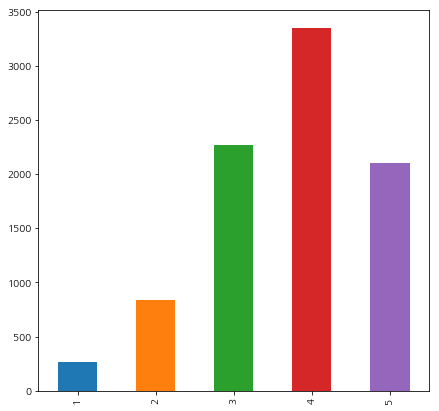

In [15]:
data['rating'].value_counts(sort=False, ascending=False).plot(kind='bar', figsize=(7,7))

### (2) 연령 분포

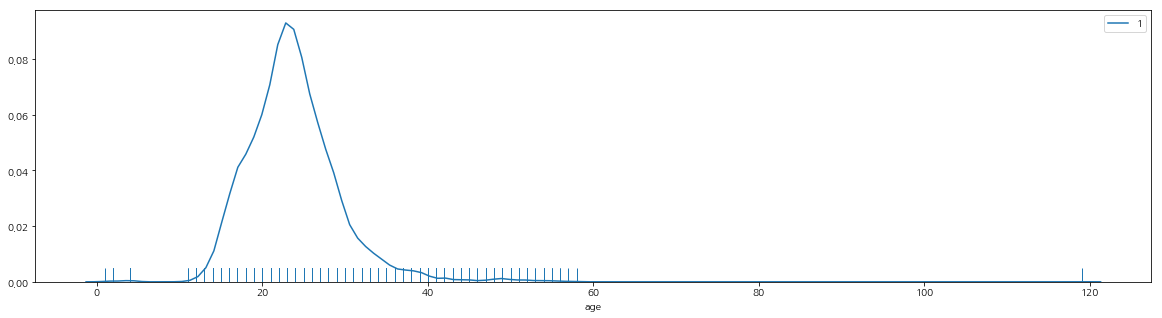

In [16]:
plt.subplots(figsize=(20,5))
sns.distplot(data.age, hist=False, label='1', kde=True, rug=True)

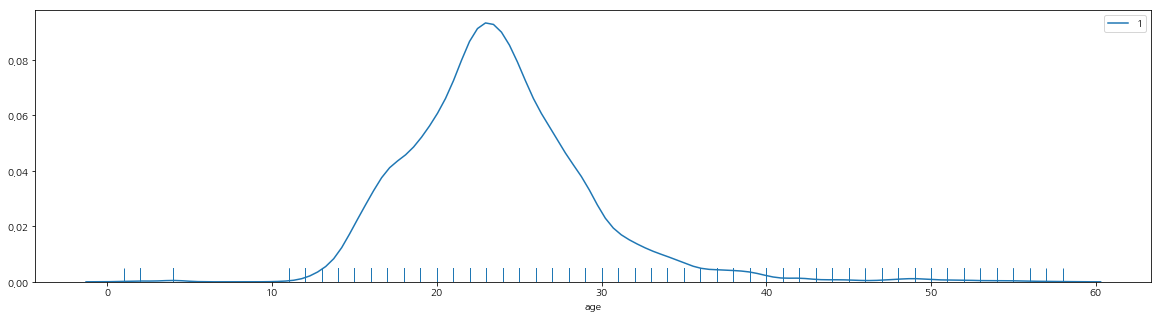

In [17]:
data = data[data['age']<60]
plt.subplots(figsize=(20,5))
sns.distplot(data.age, hist=False, label='1', kde=True, rug=True)

### (3) 성별 분포 (압도적으로 여성 다수)

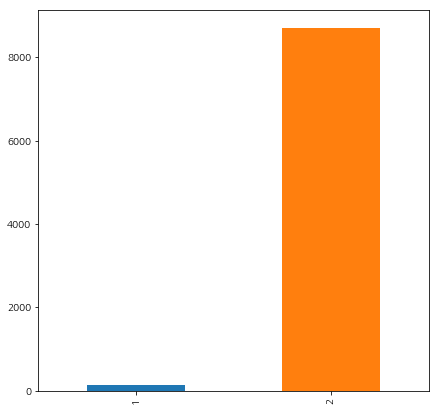

In [18]:
data['gender'].value_counts(sort=False, ascending=False).plot(kind='bar', figsize=(7,7))

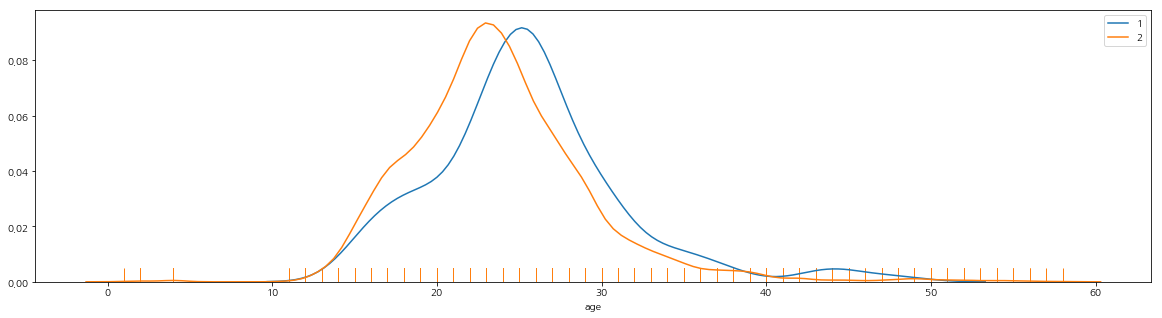

In [19]:
men = data[data['gender']==1]
women = data[data['gender']==2]

import seaborn as sns
plt.subplots(figsize=(20,5))
sns.distplot(men.age, hist=False, label='1', kde=True, rug=True)
sns.distplot(women.age, hist=False, label='2', kde=True, rug=True)

### => 여성은 20대 초반, 남성은 20대 중반

### (4) 피부타입 분포

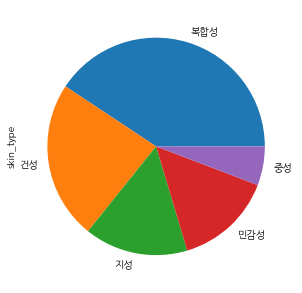

In [20]:
# sns.countplot(data=data, x='skin_type', hue='skin_type')
data['skin_type'].value_counts(sort=True, ascending=False).plot(kind='pie', figsize=(5,5))

In [22]:
All_size = len(data)
categorical = ['skin_type']
for j in categorical:
    print('cate: ', j)
    temp = 0
    col = data[j]    
    for i in range(len(col.value_counts())):
        size = col.value_counts()[i]
        print ("값", i+1, ":",'{:\u3000>5s}'.format(col.value_counts().index[i]) , "" , format(round((size/All_size)*100,2), "5.2f"), "%,", "", "( 개수 : ", size, ")")
#         print("값", i+1, ":", "%-4s" %col.value_counts().index[i], "| ", round((size/All_size)*100,2), "%,", "     ", "개수 : ", size)
        if i<=20:                 # 퍼센트합 원하는 n번째까지 더하기
            temp += round((size/All_size)*100, 2)

    print(temp, "%")           # 상위 n개 비율 합산
    print('\n')

cate:  skin_type
값 1 : 　　복합성  40.69 %,  ( 개수 :  3592 )
값 2 : 　　　건성  23.54 %,  ( 개수 :  2078 )
값 3 : 　　　지성  15.39 %,  ( 개수 :  1359 )
값 4 : 　　민감성  14.59 %,  ( 개수 :  1288 )
값 5 : 　　　중성   5.79 %,  ( 개수 :  511 )
100.0 %




## 2. 현재까지 한 것

### (1) 화장품 데이터 크롤링 : 
- 뷰티 플랫폼 사이트에서 소비자 프로파일 및 리뷰, 평점 데이터 크롤링
- 'content', 'rating', 'age', 'gender', 'nickname', 'skin_type', 'brand_name', 'product_name', 'product_id', 'brand_id'

### (2) 화장품 추천 모델
- Collaborative Filtering
- User-based : 평점 계산

In [61]:
data = pd.read_csv('data/cos_2more.csv')

In [62]:
print(data.shape)
data.head(2)

(2888, 15)


,index,content,rating,age,gender,nickname,skin_type,brand_name,product_name,product_id,brand_id,editor/rank,editor/review_count,user_id,2개이상
0,313,지금도 쓰고 있는 모찌모띠한 밀크 로션\r\n계속 쓸 예정ㅎㅎㅎ,5,22,2,쏭이누나,건성,하다라보,고쿠쥰 밀크,35073,636,9999999,20,1163758,쏭이누나
1,3588,이니스프리꺼는 정말 피부에 좋은것 같아요,4,22,2,쏭이누나,건성,이니스프리,그린티 씨드 에센스인로션,103703,186,45440,20,1163758,쏭이누나


In [63]:
df = data[['nickname', 'product_name', 'rating']]

In [64]:
print(df.shape)
df.head(1)

(2888, 3)


,nickname,product_name,rating
0,쏭이누나,고쿠쥰 밀크,5


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2888 entries, 0 to 2887
Data columns (total 3 columns):
nickname        2888 non-null object
product_name    2888 non-null object
rating          2888 non-null int64
dtypes: int64(1), object(2)
memory usage: 67.8+ KB


In [65]:
df[df['nickname'] == '서별로']

,nickname,product_name,rating
1299,서별로,자음유액,3
1300,서별로,유자 수분씨 에멀전,4
1301,서별로,애터미 로션,4
1302,서별로,에센셜 모이스처라이저,4
1303,서별로,MLE 로션,5
1304,서별로,흑석류 에멀전,1


In [33]:
# 테이블을 딕셔너리로 만드는 함수
def recur_dictify(frame):
    if len(frame.columns) == 1:
        if frame.values.size == 1: return frame.values[0][0]
        return frame.values.squeeze()
    grouped = frame.groupby(frame.columns[0])
    d = {k: recur_dictify(g.ix[:,1:]) for k,g in grouped}
    return d

In [34]:
df_to_dict = recur_dictify(df)

In [57]:
user1 = df_to_dict['서별로']

In [ ]:
df_to_dict

In [36]:
name_list = []      # 사용자 목록을 담을 리스트   # 중복 불가
cos_set = set()     # 영화 목록을 담을 set        # 중복 가능

In [37]:
# 사용자 수 만큼 반복한다.
for user_key in df_to_dict:
#     print(user_key)
    name_list.append(user_key)
    
    # 현재 사용자가 본 화장품 목록을 set에 담는다.
    for cos_key in df_to_dict[user_key] :
        # print(user_key, ":", cos_key)
        cos_set.add(cos_key)        

In [ ]:
cos_set      

In [38]:
cos_list = list(cos_set)

In [ ]:
print(name_list)              # 사용자 리스트
print(cos_list)               # 화장품 리스트

In [56]:
name_list.index('서별로')

702

In [40]:
# 학습할 데이터를 준비한다.
rating_dic = {
    'nickname' : [],
    'product_name' : [],
    'rating' : []
    }

In [41]:
# 사용자의 수 만큼 반복
for name_key in df_to_dict :
    # 해당 사용자가 본 영화 수 만큼 반복
    for cos_key in df_to_dict[name_key] :

        # 사용자 인덱스 번호를 추출한다.
        a1 = name_list.index(name_key)

        # 화장품 인덱스 번호를 추출한다.
        a2 = cos_list.index(cos_key)

        # 평점을 가져온다.
        a3 = df_to_dict[name_key][cos_key]

        # 딕셔너리에 담는다.
        rating_dic['nickname'].append(a1)
        rating_dic['product_name'].append(a2)
        rating_dic['rating'].append(a3)

In [73]:
# 사용자 - 영화 - 평점
print(len(rating_dic['nickname']))
print(len(rating_dic['product_name']))
print(len(rating_dic['rating']))

2888
2888
2888


In [74]:
# 사용자 - 영화 - 평점
print(rating_dic['nickname'])
print(rating_dic['product_name'])
print(rating_dic['rating'])

[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 14, 14, 15, 15, 16, 16, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 23, 24, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33, 34, 34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 38, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 42, 42, 43, 43, 44, 44, 45, 45, 45, 46, 46, 47, 47, 48, 48, 49, 49, 50, 50, 51, 51, 52, 52, 52, 52, 53, 53, 53, 54, 54, 54, 55, 55, 56, 56, 57, 57, 57, 57, 57, 57, 58, 58, 59, 59, 59, 59, 60, 60, 61, 61, 62, 62, 63, 63, 64, 64, 65, 65, 66, 66, 67, 67, 68, 68, 69, 69, 70, 70, 71, 71, 72, 72, 73, 73, 74, 74, 75, 75, 76, 76, 76, 77, 77, 77, 78, 78, 79, 79, 80, 80, 81, 81, 82, 82, 83, 83, 83, 84, 84, 85, 85, 85, 85, 85, 85, 86, 86, 87, 87, 87, 88, 88, 89, 89, 89, 89, 89, 89, 90, 90, 91, 91, 91, 91, 91, 91, 92, 92, 93, 93, 94, 94, 94, 95, 95, 96, 96, 97, 97, 98, 98, 99, 99, 100, 100, 101, 101, 102, 102, 103, 103, 1

In [75]:
#  데이터셋을 만든다
df = pd.DataFrame(rating_dic)

In [ ]:
df

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2888 entries, 0 to 2887
Data columns (total 3 columns):
nickname        2888 non-null int64
product_name    2888 non-null int64
rating          2888 non-null int64
dtypes: int64(3)
memory usage: 67.8 KB


In [77]:
import surprise
# 데이터를 읽어들이는 객체 생성 (rating_scale : 평점의 범위)
reader = surprise.Reader(rating_scale = (1, 5))
reader

In [78]:
# surprise 에서 사용할 데이터 셋을 구성할 때 필요한 이름
# 데이터가 저장되어 있는 딕셔너리의 컬럼 이름
# 첫번째 -> user,   두번째 -> item,   세번째 -> rating

col_list = ['nickname', 'product_name', 'rating']
data = surprise.Dataset.load_from_df(df[col_list], reader)

In [79]:
print(col_list)
print(data)

['nickname', 'product_name', 'rating']


In [80]:
# 학습한다.
trainset = data.build_full_trainset()
option = {'name' : 'pearson'}
algo = surprise.KNNBasic(sim_options=option)

algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
name_list

In [81]:
# 사용자의 화장품을 추천받는다.
who = input('닉네임을 입력해주세요: ')
print('\n')

index = name_list.index(who)
print('user_index: ',index)
print('\n')

result = algo.get_neighbors(index, k=5)
print('당신의 피부와 유사한 사용자는? : ', result)
print('\n')

# user 귯니스에 대해 화장품을 추천한다.
print('당신에게 추천드리는 화장품 : ', '\n')

for r1 in result :
    max_rating=data.df[data.df["nickname"]==r1]["rating"].max()
    cos_id=data.df[(data.df["rating"]==max_rating)&(data.df["nickname"]==r1)]["product_name"].values
    
    for cos_item in cos_id:
        print(cos_list[cos_item])

닉네임을 입력해주세요: 서별로


user_index:  702


당신의 피부와 유사한 사용자는? :  [292, 385, 933, 1064, 0]


당신에게 추천드리는 화장품 :  

MLE 로션
에센셜 모이스처라이저
로열허니 착한 에멀전
수분가득 콜라겐 에멀전
MLE 로션
더테라피 에센셜 포뮬러 에멀젼
수퍼 아쿠아 울트라 워터-풀 컨트롤 에멀젼


In [82]:
# 사용자의 화장품을 추천받는다.
who = input('닉네임을 입력해주세요: ')
print('\n')

index = name_list.index(who)
print('user_index: ',index)
print('\n')

result = algo.get_neighbors(index, k=5)
print('당신의 피부와 유사한 사용자는? : ', result)
print('\n')

# user 귯니스에 대해 화장품을 추천한다.
print('당신에게 추천드리는 화장품!!')
for r1 in result :
    max_rating=data.df[data.df["nickname"]==r1]["rating"].max()
    cos_id=data.df[(data.df["rating"]==max_rating)&(data.df["nickname"]==r1)]["product_name"].values
    
    for cos_item in cos_id:
        print(cos_list[cos_item])

닉네임을 입력해주세요: 고급진주


user_index:  324


당신의 피부와 유사한 사용자는? :  [597, 771, 972, 0, 1]


당신에게 추천드리는 화장품!!
스네일 솔루션 에멀젼
자음유액
비자 트러블 로션
더테라피 에센셜 포뮬러 에멀젼
수퍼 아쿠아 울트라 워터-풀 컨트롤 에멀젼
어린쑥 수분진정 플루이드
